# Assignment 3

You are a manager of Xstation company, which is planning to launch a video game console soon. You are planning a marketing campaign, and you want to learn more about the strengths and weaknesses of the products from your main rivals – PlayStation 4 (asin "B00BGA9WK2") and Xbox One (asin "B00KAI3KW2"). The first market to launch your product is the USA, so you will use the customer data from this market. 

In order to learn more about the competitive product, you will have to:

* **a)** Based on the ratings of Xbox One and PlayStation 4 products report the sentiment (number of positive and negative reviews) and show it using the bar chart. **(7 points)**

* **b)** Develop and update (if necessary) word clouds to examine positive and negative keywords for both PlayStation 4 and Xbox One. Report where you should put the focus to put your product in a winning position from positive and negative keywords perspective **(8 points)**

* **c)** Create a Naive Bayes Classifier for each product in order to prepare for the work with your own reviews in the future. Calculate, report and explain following scores: Accuracy, Precision, Recall and F1. Explain the difference in scores between products. Report the confusion matrix as well. **(10 points)** *NB! Use random_state = 42 when making a train-split. Points will be reduced for a different random_state.*

Make report and save it as a pdf file, attach your .ipynb code as pdf as well. You will need to submit one pdf file overall. You can write your report within ipynb file as well. 

Dataset description is available here: https://jmcauley.ucsd.edu/data/amazon/

In [ ]:
# Load necessary datasets
# DO NOT MODIFY THIS CELL

# Load the dataset with reviews from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz

# Load the dataset with metadata from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz

--2022-11-05 17:56:17--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386419180 (369M) [application/x-gzip]
Saving to: ‘reviews_Video_Games.json.gz’

reviews_Video_Games 100%[===================>] 368.52M  11.0MB/s    in 44s     

2022-11-05 17:57:02 (8.33 MB/s) - ‘reviews_Video_Games.json.gz’ saved [386419180/386419180]

--2022-11-05 17:57:02--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23557720 (22M) [application/x-gzip]
Saving to: ‘meta_Video_Games.json.gz’

meta_Video_Games.js 100%[===========

In [ ]:
# Import dependencies
# DO NOT MODIFY THIS CELL
import pandas as pd
import gzip
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from collections import Counter

from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Functions to process file with reviews 
# DO NOT MODIFY THIS CELL

# Parse all the parts of the review file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# Read json to dictionary and turn it into the Data Frame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# Fix the given products asin (Amazon Standart Identification Number)
# DO NOT MODIFY THIS CELL
asin_playstation = "B00BGA9WK2"
asin_xbox = "B00KAI3KW2"

In [ ]:
# Create DataFrame from JSON-file with reviews
# df = ...
df = getDF('reviews_Video_Games.json.gz')

In [ ]:
# Create DataFrame from JSON-file with meta data
# df_meta = ...
df_meta = getDF('meta_Video_Games.json.gz')

In [ ]:
# See the meta description of the products
# df_meta.loc[...]
df_meta.loc[df_meta['asin'].isin([asin_playstation, asin_xbox])]

,asin,description,price,imUrl,related,salesRank,categories,title,brand
45933,B00BGA9WK2,,28.12,http://ecx.images-amazon.com/images/I/41omR-LT...,"{'also_bought': ['B00BGA9X9W', 'B00CXCCI8A', '...",{'Video Games': 13},"[[Electronics, Television & Video, Blu-ray Pla...",NaN,NaN
50837,B00KAI3KW2,,399.00,http://ecx.images-amazon.com/images/I/31BUxvm4...,"{'also_bought': ['B00CMQTUSS', 'B00FM5IY4W', '...",{'Video Games': 46},"[[Video Games, Xbox One, Consoles]]",NaN,NaN


In [ ]:
# Create product-related data frames 
# df_playstation = ...
# df_xbox = ...
df_playstation = df[df.asin.isin([asin_playstation])]
df_xbox = df[df.asin.isin([asin_xbox])]

In [ ]:
# Check the distribution of ratings for PlayStation 4
df_playstation['overall'].value_counts()

5.0    5123
1.0    1327
4.0     691
3.0     269
2.0     151
Name: overall, dtype: int64

In [ ]:
# Check the distribution of ratings for Xbox One
df_xbox['overall'].value_counts()

5.0    71
1.0    23
4.0    12
2.0     3
3.0     3
Name: overall, dtype: int64

In [ ]:
# For each product create new Data Frame and leave there only review text and rating
# df_playstation_text = ...
# df_xbox_text = ...
df_playstation_text = df_playstation[['reviewText','overall']].reset_index(drop=True)
df_xbox_text = df_xbox[['reviewText','overall']].reset_index(drop=True)

In [ ]:
# Create column "Sentiment" for sentiment values (0 - negative, 1 - positive). Sentiment is positive if "overall" rating value is >= 4.0
# df_playstation_text["Sentiment"] = 
# df_xbox_text["Sentiment"] = 

df_playstation_text["Sentiment"] = df_playstation_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)
df_xbox_text["Sentiment"] = df_xbox_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)

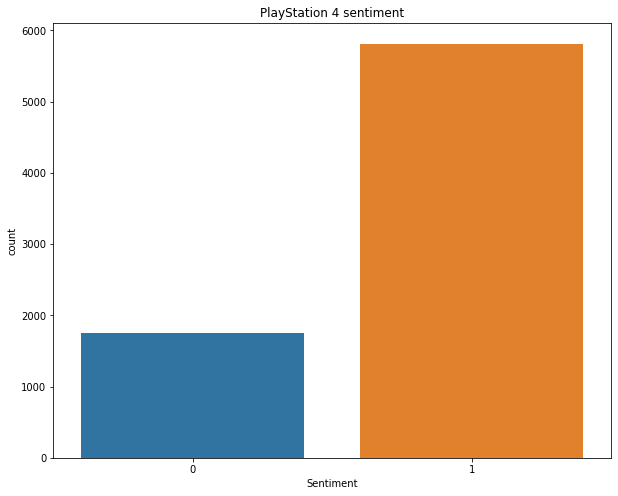

In [ ]:
# Plot sentiment for PlayStation 4
# DO NOT MODIFY THIS CELL

plt.figure(figsize = (10, 8))
sns.countplot(data = df_playstation_text, x = 'Sentiment')
plt.title("PlayStation 4 sentiment")
plt.show()

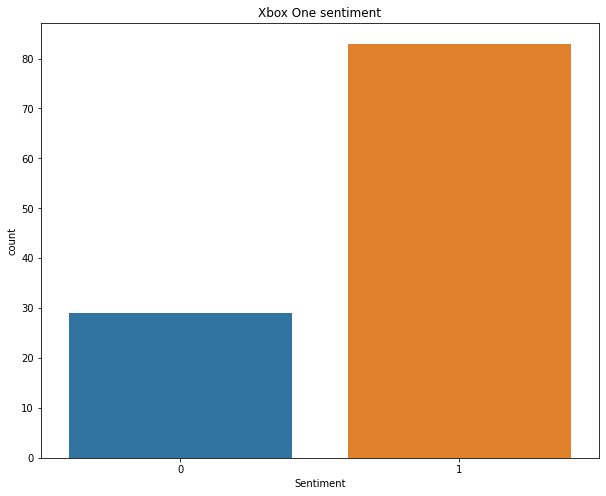

In [ ]:
# Plot sentiment for Xbox One
# DO NOT MODIFY THIS CELL

plt.figure(figsize = (10, 8))
sns.countplot(data = df_xbox_text, x = 'Sentiment')
plt.title("Xbox One sentiment")
plt.show()

In [ ]:
# Create functions to clean the text
# DO NOT MODIFY THIS CELL

# Function to clean text
def clean_text(Review):   
  Review = str(Review).lower() # convert to lowercase
  Review = re.sub('\[.*?\]', '', Review)  # Remove special symbols
  Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
  Review = re.sub('<.*?>+', '', Review) # Remove special symbols
  Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
  Review = re.sub('\n', '', Review) # Remove forced enter
  Review = re.sub('\w*\d\w*', '', Review) # Remove metacharachters
  return Review
  
# Function to convert list to string 
def listToString(s):
   
  # initialize an empty string
  str1 = " "
  
  # return string 
  return (str1.join(s))

# Function to remove stopwords
def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

In [ ]:
# Load standard list of stopwords
# stop_words = ...

stop_words = stopwords.words('english')

In [ ]:
# Clean review texts for PlayStation 4
# df_playstation_text['review'] = df_playstation_text['reviewText'].apply(...)
# df_playstation_text['review'] = ...
df_playstation_text['review'] = df_playstation_text['reviewText'].apply(clean_text)
df_playstation_text['review'] = df_playstation_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Clean review for Xbox One
# df_xbox_text['review'] = df_xbox_text['reviewText'].apply(...)
# df_xbox_text['review'] = ...

df_xbox_text['review'] = df_xbox_text['reviewText'].apply(clean_text)
df_xbox_text['review'] = df_xbox_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Check how clean reviews look for PlayStation 4 or Xbox
df_playstation_text.head(10)

,reviewText,overall,Sentiment,review
0,I'm so upset at how Sony is ripping people off...,1.0,0,im upset sony ripping people game system son r...
1,I gave it 4 out of 5 stars because of lack of ...,4.0,1,gave stars lack games otherwise would gotten c...
2,I have only Nintendo products in the past. Eve...,5.0,1,nintendo products past everything read playsta...
3,I love this PS4. Even though the game selectio...,5.0,1,love even though game selection still big qual...
4,I placed my order around June and received my ...,5.0,1,placed order around june received new day rele...
5,PlayStation 4 is kind of hard to review right ...,3.0,0,playstation kind hard review right missing man...
6,Simply amazing. A huge step up from the PS3 an...,5.0,1,simply amazing huge step huge step xbox one ge...
7,So I had a hard time finding a ps4 at my local...,5.0,1,hard time finding local gaming stores told sol...
8,The best PlayStation yet. I like how they made...,5.0,1,best playstation yet like made easy upgrade ha...
9,"The PS4 is a beautiful machine, but beware the...",3.0,0,beautiful machine beware lack features time go...


In [ ]:
# Create a Data Frame with negative reviews for PlayStation 4
df_playstation_neg = df_playstation_text[df_playstation_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for PlayStation 4
df_playstation_pos = df_playstation_text[df_playstation_text.Sentiment == 1][["review"]].reset_index()

In [ ]:
# Create a Data Frame with negative reviews for Xbox One
df_xbox_neg = df_xbox_text[df_xbox_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for Xbox One
df_xbox_pos = df_xbox_text[df_xbox_text.Sentiment == 1][["review"]].reset_index()

In [ ]:
# Create function, that creates string for a word cloud
# DO NOT MODIFY THIS CELL
def create_string(col):
  string = ''
  for val in col:
    list = nltk.word_tokenize(val)
    for m in list:
      string += " " + m
  return string

In [ ]:
# Create string for a word cloud for negative reviews for PlayStation 4
# string_playstation_neg = create_string()
string_playstation_neg = create_string(df_playstation_neg["review"])

# Create string for a word cloud for positive reviews for PlayStation 4
# string_playstation_pos = create_string()
string_playstation_pos = create_string(df_playstation_pos["review"])

# Create string for a word cloud for negative reviews for Xbox One
# string_xbox_neg = create_string()
string_xbox_neg = create_string(df_xbox_neg["review"])

# Create string for a word cloud for positive reviews for Xbox One
# string_xbox_pos = create_string()
string_xbox_pos = create_string(df_xbox_pos["review"])

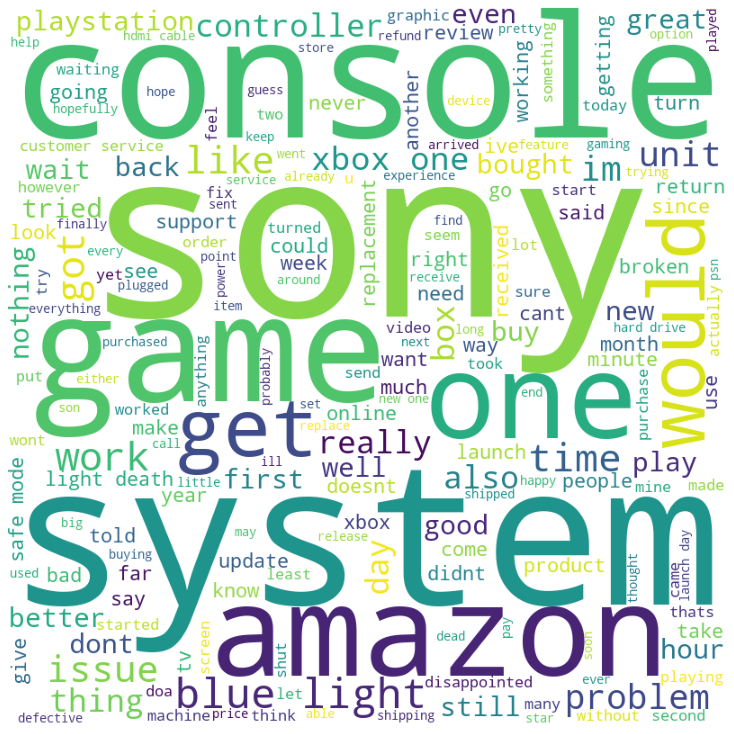

In [ ]:
# Create wordcloud for negative reviews for PlayStation 4
wordcloud_playstation_neg = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_playstation_neg)


# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_playstation_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

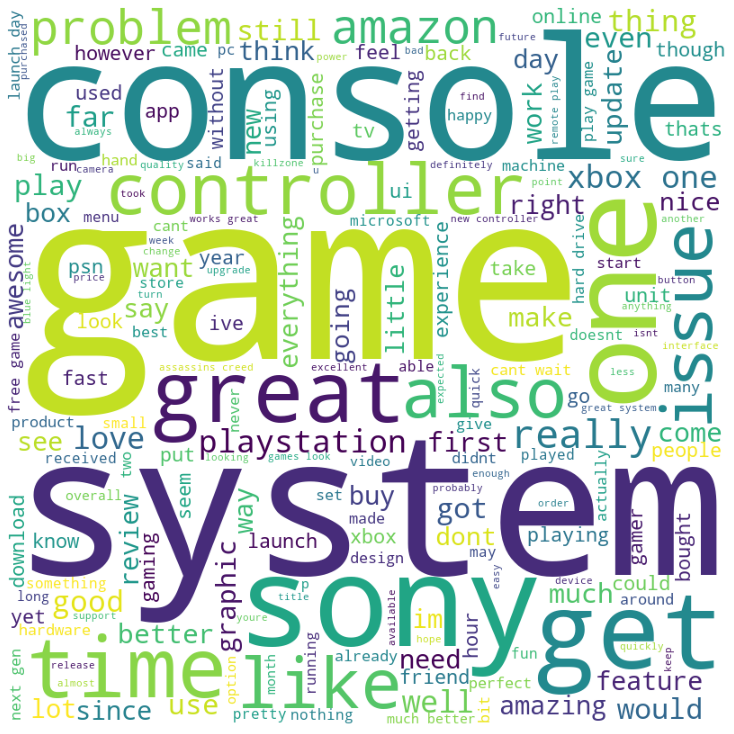

In [ ]:
# Create wordcloud for positive reviews for PlayStation 4
wordcloud_playstation_pos = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_playstation_pos)


# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_playstation_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

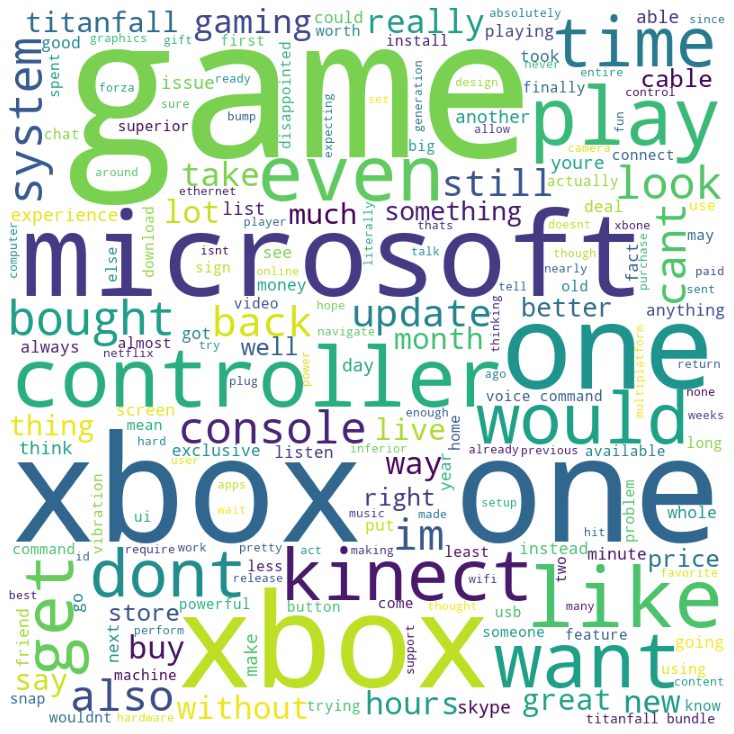

In [ ]:
# Create wordcloud for negative reviews for Xbox One
wordcloud_xbox_neg = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_xbox_neg)


# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_xbox_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

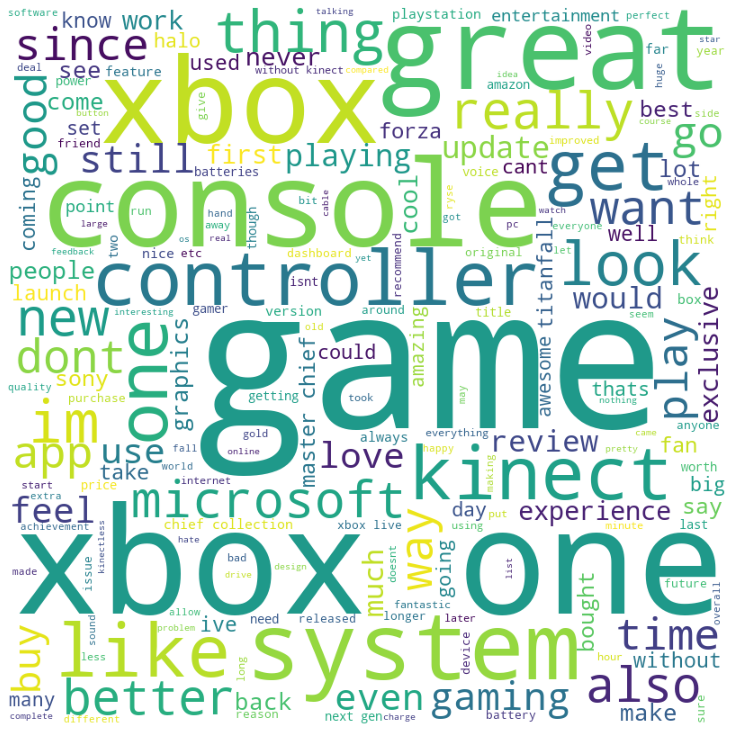

In [ ]:
# Create wordcloud for positive reviews for Xbox One
wordcloud_xbox_pos = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_xbox_pos)


# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_xbox_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
# Update stop words if necessary and build new word clouds


In [ ]:
# Create vectors for features and labels for PlayStation 4
# X_playstation = ...
# y_playstation = ...

X_playstation = df_playstation_text['review']
y_playstation = df_playstation_text['Sentiment']

In [ ]:
# Create vectors for features and labels for Xbox One
# X_xbox = ...
# y_xbox = ...

X_xbox = df_xbox_text['review']
y_xbox = df_xbox_text['Sentiment']

In [ ]:
# Make a train-test split for PlayStation 4
# X_playstation_train, X_playstation_test, y_playstation_train, y_playstation_test =
X_playstation_train, X_playstation_test, y_playstation_train, y_playstation_test = train_test_split(X_playstation, y_playstation, random_state = 42, test_size = 0.20)

In [ ]:
# Make a train-test split for Xbox One
# X_xbox_train, X_xbox_test, y_xbox_train, y_xbox_test = ...
X_xbox_train, X_xbox_test, y_xbox_train, y_xbox_test = train_test_split(X_xbox, y_xbox, random_state = 42, test_size = 0.20)

Test accuracy: 0.806
Precision: 0.800
Recall: 0.997
F1 Score: 0.887


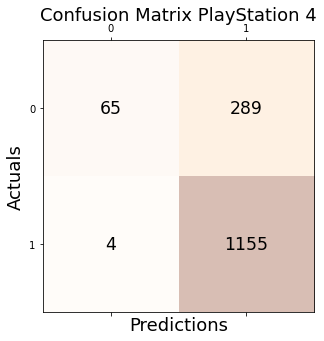

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for PlayStation 4
# clf_playstation = Pipeline (...)
clf_playstation = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for PlayStation 4
# clf_playstation. ...
clf_playstation.fit(X_playstation_train,y_playstation_train)


# Predict results on test data for PlayStation 4
# y_playstation_pred =
y_playstation_pred = clf_playstation.predict(X_playstation_test)

# Print model metrics for PlayStation 4
# print('Test accuracy: %.3f' % ...)
# print('Precision: %.3f' % ...)
# print('Recall: %.3f' % ...)
# print('F1 Score: %.3f' % ...)

print('Test accuracy: %.3f' % accuracy_score(y_playstation_test, y_playstation_pred))
print('Precision: %.3f' % precision_score(y_playstation_test, y_playstation_pred))
print('Recall: %.3f' % recall_score(y_playstation_test, y_playstation_pred))
print('F1 Score: %.3f' % f1_score(y_playstation_test, y_playstation_pred))

# Create a confusion matrix for PlayStation 4 and print it

conf_matrix_playstation = confusion_matrix(y_true=y_playstation_test, y_pred=y_playstation_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_playstation, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_playstation.shape[0]):
    for j in range(conf_matrix_playstation.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_playstation[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix PlayStation 4', fontsize=18)
plt.show()

Test accuracy: 0.826
Precision: 0.826
Recall: 1.000
F1 Score: 0.905


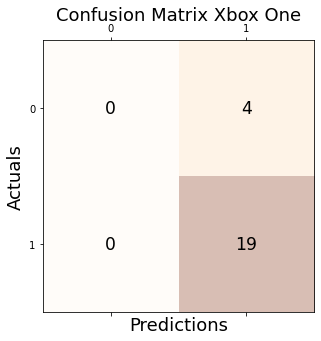

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for Xbox One
# clf_xbox = Pipeline (...)
clf_xbox = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for Xbox One
# clf_xbox. ...
clf_xbox.fit(X_xbox_train,y_xbox_train)


# Predict results on test data for Xbox One
# y_xbox_pred =
y_xbox_pred = clf_xbox.predict(X_xbox_test)

# Print model metrics for Xbox One
# print('Test accuracy: %.3f' % ...)
# print('Precision: %.3f' % ...)
# print('Recall: %.3f' % ...)
# print('F1 Score: %.3f' % ...)

print('Test accuracy: %.3f' % accuracy_score(y_xbox_test, y_xbox_pred))
print('Precision: %.3f' % precision_score(y_xbox_test, y_xbox_pred))
print('Recall: %.3f' % recall_score(y_xbox_test, y_xbox_pred))
print('F1 Score: %.3f' % f1_score(y_xbox_test, y_xbox_pred))

# Create a confusion matrix for Xbox One and print it

conf_matrix_xbox = confusion_matrix(y_true=y_xbox_test, y_pred=y_xbox_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_xbox, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_xbox.shape[0]):
    for j in range(conf_matrix_xbox.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_xbox[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Xbox One', fontsize=18)
plt.show()
